# Predcition of Hospital Admission Related to Urinary Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to urinary tract infection (UTI). We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) and random forest (RF) models.

In [13]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [14]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [15]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [16]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'uti_date_'+str(i), 'uti_ab_date_'+str(i), 'uti_ab_type_'+str(i),
                   'incdt_uti_date_'+str(i), 'admitted_uti_date_'+str(i), 'sgss_gp_cov_uti_date_'+str(i)]]
    
    #drop rows with no uti reord
    datum = datum[datum['uti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with uti_i
    datum = datum[datum['sgss_gp_cov_uti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'uti_date_'+str(i): 'uti_date', 'uti_ab_date_'+str(i): 'uti_ab_date', 
                           'uti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_uti_date_'+str(i): 'incdt_uti_date', 'incdt_uti_type_'+str(i): 'incdt_uti_type',
                           'admitted_uti_date_'+str(i): 'admitted_uti_date',
                           'sgss_gp_cov_uti_date_'+str(i): 'sgss_gp_cov_uti_date'},
                inplace=True)
    
    return datum

In [17]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req_enc

In [18]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred_enc_lr_rf):
    #calculate sums
    summary_table = prob_pred_enc_lr_rf.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr_rf.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr_rf.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [19]:
def cox_build(infection, infection_type, data, data_no_abs): #data_uti_incdt, data_uti_no_abs_incdt
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_uti_admitted',
            event_col='event_uti_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']
    #prob_pred_uti_no_abs_incdt

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    #prob_pred

    ##add a column for prescribed antibiotics
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    #prob_pred_uti_no_abs_incdt_bin
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [20]:
def lr_rf_build_risk(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'bins']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)#, random_state=42)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nLR AUROC with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('RF AUROC with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    # plt.title("ROC curve of LR and RF model", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [21]:
def calibration_rf_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val):
    ##calibration for RF
    rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of RF model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [22]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_uti.csv.gz')

In [23]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [24]:
#process 20 utis and concatenate them 
data_uti_1 = proc_infec_data(data,1)
data_uti_2 = proc_infec_data(data,2)
data_uti_3 = proc_infec_data(data,3)
data_uti_4 = proc_infec_data(data,4)
data_uti_5 = proc_infec_data(data,5)
data_uti_6 = proc_infec_data(data,6)
data_uti_7 = proc_infec_data(data,7)
data_uti_8 = proc_infec_data(data,8)
data_uti_9 = proc_infec_data(data,9)
data_uti_10 = proc_infec_data(data,10)
data_uti_11 = proc_infec_data(data,11)
data_uti_12 = proc_infec_data(data,12)
data_uti_13 = proc_infec_data(data,13)
data_uti_14 = proc_infec_data(data,14)
data_uti_15 = proc_infec_data(data,15)
data_uti_16 = proc_infec_data(data,16)
data_uti_17 = proc_infec_data(data,17)
data_uti_18 = proc_infec_data(data,18)
data_uti_19 = proc_infec_data(data,19)
data_uti_20 = proc_infec_data(data,20)

data_uti = pd.concat([data_uti_1, data_uti_2, data_uti_3, data_uti_4, data_uti_5, data_uti_6, data_uti_7, data_uti_8, data_uti_9, data_uti_10, data_uti_11, data_uti_12, data_uti_13, data_uti_14, data_uti_15, data_uti_16, data_uti_17, data_uti_18, data_uti_19, data_uti_20])
data_uti.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [25]:
##add variable season
#convert data types
data_uti['uti_date'] = data_uti['uti_date'].astype('datetime64[ns]')
data_uti['admitted_uti_date'] = data_uti['admitted_uti_date'].astype('datetime64[ns]')
data_uti.died_date = data_uti.died_date.astype('datetime64[ns]')
data_uti.deregistered_date = data_uti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_uti['date'] = data_uti['uti_date'] 
data_uti['date'] = data_uti['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_uti with today's date in year and month
data_uti = data_uti[data_uti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_uti = data_uti[data_uti['date'] != last_1_month_date_y_m]
data_uti = data_uti[data_uti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of uti records
data_uti['season'] = np.nan
data_uti['date_month'] = pd.DatetimeIndex(data_uti['date']).month

conditions = [
    (data_uti['date_month'] >= 3) & (data_uti['date_month'] <= 5),
    (data_uti['date_month'] >= 6) & (data_uti['date_month'] <= 8),
    (data_uti['date_month'] >= 9) & (data_uti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_uti['season'] = np.select(conditions, choices, default='winter')

In [26]:
#add variable time period
data_uti.loc[(data_uti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_uti.loc[((data_uti['date'] >= '2020-01') & (data_uti['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_uti.loc[(data_uti['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

In [27]:
data_uti['date'].max()

'2023-03'

#### event and duration

In [28]:
#scenario 1
#not hosped (nothing happened)
data_uti.loc[data_uti['admitted_uti_date'].isnull(), 'event_uti_admitted'] = 0

In [29]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_uti['delta_uti_admitted'] = (data_uti['admitted_uti_date'] - data_uti['uti_date']).dt.days
data_uti.loc[((data_uti['delta_uti_admitted'] >= 0) & (data_uti['delta_uti_admitted'] <= 30)), 'event_uti_admitted'] = 1

#scenario 2
#drop whoever was admitted before uti consultation, i.e. negative value for delta_uti_admitted
data_uti = data_uti[~(data_uti['delta_uti_admitted'] < 0)]

In [30]:
#scenario 3
#censor died patients
data_uti['delta_admitted_died'] = (data_uti['died_date'] - data_uti['admitted_uti_date']).dt.days
data_uti.loc[data_uti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_uti.loc[((data_uti['delta_admitted_died'] >= 0) & (data_uti['delta_admitted_died'] <= 30)), 'event_uti_admitted'] = 0

#scenario 3
#censor deregistered patients
data_uti['delta_admitted_deregistered'] = (data_uti['deregistered_date'] - data_uti['admitted_uti_date']).dt.days
data_uti.loc[data_uti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_uti.loc[((data_uti['delta_admitted_deregistered'] > 0) & (data_uti['delta_admitted_deregistered'] <= 30)), 'event_uti_admitted'] = 0

#agg scenario 3s
data_uti['delta_admitted_died_deregistered'] = data_uti['delta_admitted_deregistered'].combine_first(data_uti['delta_admitted_died'])
data_uti.loc[data_uti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [31]:
#scenario 1
#any other patients (nothing happened)
data_uti['event_uti_admitted'] = data_uti['event_uti_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_uti['duration_uti_admitted'] = data_uti['delta_uti_admitted'].combine_first(data_uti['delta_admitted_died_deregistered'])
data_uti['duration_uti_admitted'] = data_uti['duration_uti_admitted'].replace(np.NaN, 30)
data_uti.loc[(data_uti['duration_uti_admitted'] > 30), 'duration_uti_admitted'] = 30

#give value 1 to event_uti_admitted if duration_uti_admitted is greater or equal to 0 and less than 30
data_uti.loc[((data_uti['duration_uti_admitted'] >= 0) & (data_uti['duration_uti_admitted'] < 30)), 'event_uti_admitted'] = 1

#drop any rows with value 0 in duration column
data_uti = data_uti[~(data_uti['duration_uti_admitted'] == 0)]

In [32]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_uti.loc[((data_uti['delta_uti_admitted'] > 0) & (data_uti['delta_uti_admitted'] < 30)), 'event_uti_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [33]:
#drop anybody with age less than 18 or 0!
data_uti = data_uti[~(data_uti['age'] < 18)] 
data_uti['age'][data_uti['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_uti = data_uti[data_uti['age_cat'] != '0-4']
data_uti = data_uti[data_uti['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_uti['bmi'][data_uti['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_uti['bmi'] = data_uti['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_uti['antibacterial_brit'][data_uti['antibacterial_brit'] < 0] = np.nan

In [34]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking_status = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_uti = data_uti.replace({"sex": dict_sex})
data_uti = data_uti.replace({"smoking_status": dict_smoking_status})

In [35]:
#drop rows with missing region
if ('region' in data_uti.columns) and (data_uti['region'].isnull().sum() > 0):
   data_uti = data_uti[data_uti['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_uti.columns) and (data_uti['antibacterial_brit'].isnull().sum() > 0):
    data_uti['antibacterial_brit'] = data_uti['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_uti.columns) and (data_uti['ethnicity'].isnull().sum() > 0):
    data_uti['ethnicity'] = data_uti['ethnicity'].fillna(0)

#replace rows with missing smoking_status with 0
if ('smoking_status' in data_uti.columns) and (data_uti['smoking_status'].isnull().sum() > 0):
    data_uti['smoking_status'] = data_uti['smoking_status'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_uti.columns) and (data_uti['imd'].isnull().sum() > 0):
    data_uti['imd'] = data_uti['imd'].fillna(0)

In [36]:
#missing values of bmi assign 5 and 0; categorise bmi
data_uti['bmi_cat'] = 5

for idx, x in enumerate(data_uti['bmi_cat']):
    if data_uti.iat[idx, data_uti.columns.get_loc('bmi')] >= 30:
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] >= 25) and (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] < 30):
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] >= 18.5) and (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] < 25):
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_uti.iat[idx, data_uti.columns.get_loc('bmi')] < 18.5:
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_uti.columns) and (data_uti['bmi_cat'].isnull().sum() > 0):
    data_uti['bmi_cat'] = data_uti['bmi_cat'].fillna(0)

In [37]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_uti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_uti['ab_type_cat'] = np.where(data_uti['ab_type'].isin(ab_series[mask].index),'other',data_uti['ab_type'])
#assign no to non ab users
data_uti.loc[data_uti['uti_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_uti['ab_type_cat'] = data_uti['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [38]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking_status = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_uti = data_uti.replace({"sex": dict_sex})
data_uti = data_uti.replace({"ethnicity": dict_ethnicity})
data_uti = data_uti.replace({"smoking_status": dict_smoking_status})
data_uti = data_uti.replace({"imd": dict_imd})
data_uti = data_uti.replace({"bmi_cat": dict_bmi})
data_uti = data_uti.replace({"flu_vaccine": dict_flu})
data_uti = data_uti.replace({"region": dict_region})
data_uti = data_uti.replace({"age_cat": dict_age})
data_uti = data_uti.replace({"ab_type_cat": dict_ab_type})

In [39]:
data_uti.ethnicity.value_counts('NA')

white      0.600208
unknown    0.251877
asian      0.074042
other      0.073873
Name: ethnicity, dtype: float64

In [40]:
data_uti.smoking_status.value_counts('NA')

unknown         0.416037
smoker          0.389702
never_smoked    0.128224
ex_smoker       0.066037
Name: smoking_status, dtype: float64

In [41]:
data_uti.bmi_cat.value_counts('NA')

obese             0.515868
unknown           0.257797
overweight        0.111321
healthy_weight    0.083080
underweight       0.031934
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [42]:
#categorise CCI
data_uti['CCI_cat'] = pd.cut(data_uti['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_uti['antibacterial_brit'].clip(0, data_uti['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

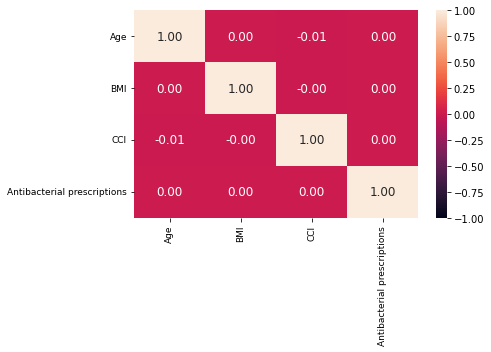

In [43]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_uti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_uti/corr_uti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [44]:
data_uti = data_uti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                                   'antibacterial_brit', 'uti_ab_date', 'ab_type_cat', 'incdt_uti_date', 'date', 'period',
                                   'event_uti_admitted', 'duration_uti_admitted'
                                    ]]

In [45]:
#switch variable uti_ab_date into a binary variable
data_uti[['ab_binary']] = data_uti[['uti_ab_date']].where(data_uti[['uti_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_uti_incdt = data_uti[data_uti['incdt_uti_date'] == 0]
data_uti_prevl = data_uti[data_uti['incdt_uti_date'] == 1]

#no antibiotics and incident hospital admission
data_uti_no_abs_incdt = data_uti_incdt[data_uti_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_uti_abs_incdt = data_uti_incdt[data_uti_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_uti_no_abs_prevl = data_uti_prevl[data_uti_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_uti_abs_prevl = data_uti_prevl[data_uti_prevl['ab_binary'] == 1]

In [46]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_uti_incdt_prepandemic = data_uti_incdt[data_uti_incdt['period'] == 'prepandemic']
data_uti_incdt_during_pandemic = data_uti_incdt[(data_uti_incdt['period'] == 'during_pandemic')]
data_uti_incdt_post_2nd_lockdown = data_uti_incdt[data_uti_incdt['period'] == 'post_2nd_lockdown']
data_uti_prevl_prepandemic = data_uti_prevl[data_uti_prevl['period'] == 'prepandemic']
data_uti_prevl_during_pandemic = data_uti_prevl[(data_uti_prevl['period'] == 'during_pandemic')]
data_uti_prevl_post_2nd_lockdown = data_uti_prevl[data_uti_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_uti_no_abs_incdt_prepandemic = data_uti_incdt_prepandemic[data_uti_incdt_prepandemic['ab_binary'] == 0]
data_uti_no_abs_incdt_during_pandemic = data_uti_incdt_during_pandemic[data_uti_incdt_during_pandemic['ab_binary'] == 0]
data_uti_no_abs_incdt_post_2nd_lockdown = data_uti_incdt_post_2nd_lockdown[data_uti_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_uti_no_abs_prevl_prepandemic = data_uti_prevl_prepandemic[data_uti_prevl_prepandemic['ab_binary'] == 0]
data_uti_no_abs_prevl_during_pandemic = data_uti_prevl_during_pandemic[data_uti_prevl_during_pandemic['ab_binary'] == 0]
data_uti_no_abs_prevl_post_2nd_lockdown = data_uti_prevl_post_2nd_lockdown[data_uti_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [47]:
#store data for plotting hosp admission counts and percentages
%store data_uti
# save data
data_uti.to_csv('../output/hospitalisation_prediction_uti/data_uti.csv')

Stored 'data_uti' (DataFrame)


In [48]:
data_uti_incdt

,age_cat,sex,CCI_cat,flu_vaccine,bmi_cat,region,imd,ethnicity,smoking_status,season,antibacterial_brit,uti_ab_date,ab_type_cat,incdt_uti_date,date,period,event_uti_admitted,duration_uti_admitted,ab_binary
3,15_24,female,high,no,obese,west_midlands,very_affluent,unknown,unknown,autumn,2.0,NaN,no,0,2019-10,prepandemic,0.0,30.0,0
4,75_more,male,medium,no,unknown,east_midlands,very_affluent,asian,smoker,spring,0.0,NaN,no,0,2020-04,during_pandemic,0.0,30.0,0
5,15_24,male,low,no,unknown,west_midlands,medium,white,smoker,winter,0.0,NaN,no,0,2020-02,during_pandemic,0.0,30.0,0
7,25_34,male,very_high,no,unknown,london,very_unaffluent,white,ex_smoker,winter,0.0,NaN,no,0,2021-01,during_pandemic,0.0,30.0,0
9,15_24,male,low,no,unknown,london,medium,white,smoker,autumn,0.0,NaN,no,0,2019-10,prepandemic,0.0,30.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359746,15_24,male,low,no,obese,north_west,very_unaffluent,white,ex_smoker,winter,2.0,NaN,no,0,2021-01,during_pandemic,0.0,30.0,0
359747,35_44,female,very_high,no,obese,yorkshire,unaffluent,white,unknown,winter,2.0,NaN,no,0,2020-12,during_pandemic,0.0,30.0,0
359748,65_74,male,high,no,unknown,london,affluent,white,ex_smoker,autumn,0.0,2022-11-02,other,0,2019-10,prepandemic,0.0,30.0,1
359751,15_24,male,low,yes,obese,south_east,very_unaffluent,unknown,smoker,autumn,1.0,2019-03-19,other,0,2021-09,post_2nd_lockdown,0.0,30.0,1


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-1- incident

<lifelines.CoxPHFitter: fitted with 108066 total observations, 107364 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 108066
number of events observed = 702
   partial log-likelihood = -8110.48
         time fit was run = 2023-06-27 16:04:32 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.02       1.02       0.11            -0.20             0.24                 0.82                 1.27
CCI_cat[T.medium]               -0.03       0.97       0.13            -0.28             0.22                 0.76                 1.25
CCI_cat[T.high]                  0.18       1.20       0.14            -0.10             0.46                 0.91                 1.59
CCI_cat[T.very_high]             0.15       1.16       0.13            -0.11             0.40                 0.90                 1.49
age_cat[T.25_34]                -0.11       0.89       0.14            -0.38             0.16                 0.68                 1.18
age_cat[T.35_44]                -0.24       0.79       0.14            -0.52             0.04                 0.59                 1.05
age_cat[T.45_54]                 0.04       1.04       0.13            -0.22             0.31                 0.80                 1.36
age_cat[T.55_64]                -0.18       0.84       0.14            -0.46             0.10                 0.63                 1.11
age_cat[T.65_74]                -0.12       0.89       0.14            -0.39             0.16                 0.67                 1.17
age_cat[T.75_more]               0.00       1.00       0.14            -0.27             0.27                 0.77                 1.31
antibacterial_brit              -0.07       0.93       0.03            -0.12            -0.02                 0.88                 0.98
bmi_cat[T.obese]                 0.16       1.17       0.15            -0.13             0.44                 0.88                 1.56
bmi_cat[T.overweight]            0.00       1.00       0.18            -0.35             0.36                 0.70                 1.43
bmi_cat[T.underweight]           0.28       1.33       0.24            -0.18             0.75                 0.83                 2.11
bmi_cat[T.unknown]              -0.01       0.99       0.16            -0.32             0.30                 0.73                 1.35
ethnicity[T.other]              -0.18       0.83       0.19            -0.56             0.20                 0.57                 1.22
ethnicity[T.unknown]            -0.13       0.88       0.15            -0.43             0.16                 0.65                 1.18
ethnicity[T.white]              -0.13       0.88       0.14            -0.40             0.14                 0.67                 1.15
flu_vaccine[T.yes]              -0.13       0.88       0.13            -0.39             0.13                 0.68                 1.13
imd[T.medium]                    0.08       1.09       0.12            -0.15             0.31                 0.86                 1.37
imd[T.unaffluent]               -0.12       0.88       0.12            -0.37             0.12                 0.69                 1.13
imd[T.unknown]                   0.24       1.27       0.17            -0.10             0.58                 0.90                 1.78
imd[T.very_affluent]            -0.02       0.98       0.12            -0.26             0.21                 0.77                 1.24
imd[T.very_unaffluent]          -0.16       0.85       0.13            -0.41             0.08                 0.66                 1.09
region[T.east_midlands]         -0.08       0.93       0.18        

13049


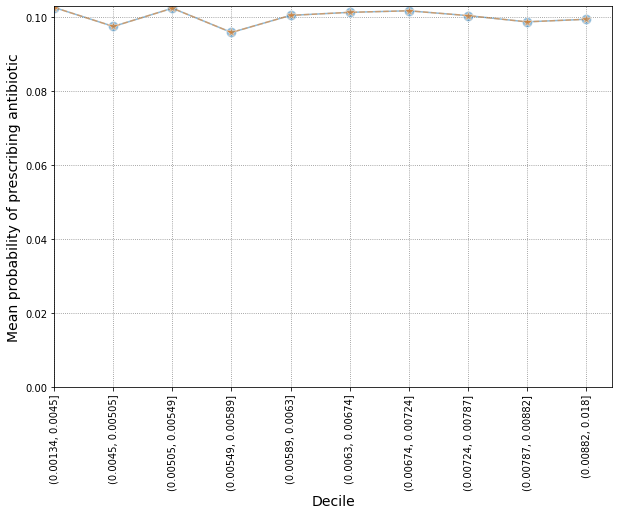


LR AUROC with development and validation data: 0.51892 and 0.50656
RF AUROC with development and validation data: 0.61929 and 0.50278
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.947711       NaN       NaN
age_cat_25_34                0.883510       NaN       NaN
age_cat_35_44                0.888944       NaN       NaN
age_cat_45_54                0.851568       NaN       NaN
age_cat_55_64                0.885537       NaN       NaN
age_cat_65_74                0.919708       NaN       NaN
age_cat_75_more              0.847551       NaN       NaN
sex_female                   0.661401       NaN       NaN
sex_male                     0.661514  0.000000       inf
CCI_cat_high                 0.817286       NaN       NaN
CCI_cat_low                  0.846737       NaN       NaN
CCI_cat_medium               0.869035       NaN       NaN
CCI_cat_very_high            0.883232       NaN       NaN
CCI_cat_very_low             0.8237

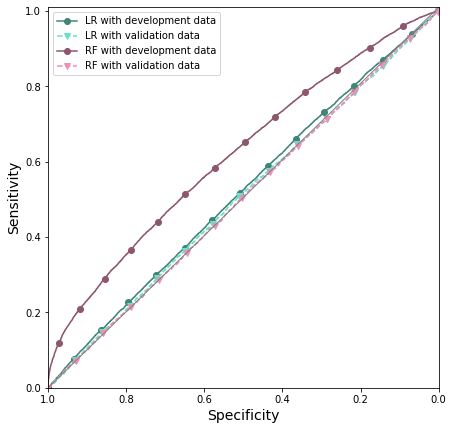

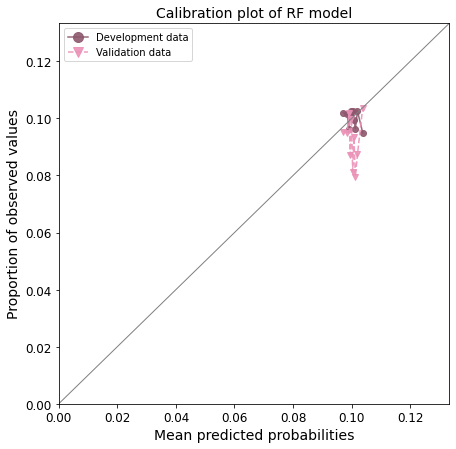

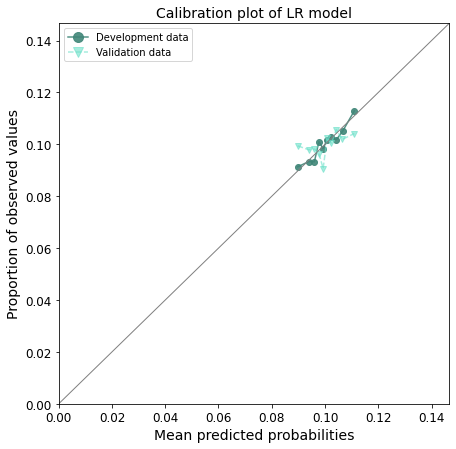

In [49]:
#build cox model for hosp prediction using non ab users' data
prob_pred_uti_no_abs_incdt, prob_pred_uti_no_abs_incdt_bin = cox_build('uti', 'incdt', data_uti_incdt, data_uti_no_abs_incdt)

#build rf and lr models
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk('uti', 'incdt', prob_pred_uti_no_abs_incdt)

#make summary table
make_summary_table('uti', 'incdt', prob_pred_enc_lr_rf_incdt)

#calibration plots of rf and lr
calibration_rf_lr('uti', 'incdt', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 11999 total observations, 11921 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 11999
number of events observed = 78
   partial log-likelihood = -710.91
         time fit was run = 2023-06-27 16:05:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.31       1.37       0.37            -0.41             1.04                 0.66                 2.82
CCI_cat[T.medium]               -0.31       0.73       0.46            -1.21             0.59                 0.30                 1.81
CCI_cat[T.high]                  0.36       1.44       0.46            -0.54             1.27                 0.58                 3.54
CCI_cat[T.very_high]             0.77       2.16       0.38             0.02             1.52                 1.02                 4.58
age_cat[T.25_34]                -0.17       0.85       0.49            -1.12             0.79                 0.33                 2.20
age_cat[T.35_44]                 0.57       1.77       0.42            -0.26             1.40                 0.77                 4.05
age_cat[T.45_54]                 0.33       1.39       0.44            -0.54             1.19                 0.58                 3.29
age_cat[T.55_64]                 0.25       1.28       0.44            -0.62             1.12                 0.54                 3.05
age_cat[T.65_74]                 0.36       1.44       0.43            -0.49             1.22                 0.61                 3.37
age_cat[T.75_more]               0.02       1.02       0.47            -0.90             0.95                 0.41                 2.58
antibacterial_brit               0.03       1.03       0.08            -0.12             0.19                 0.89                 1.20
bmi_cat[T.obese]                -0.57       0.56       0.36            -1.28             0.14                 0.28                 1.15
bmi_cat[T.overweight]           -0.80       0.45       0.52            -1.81             0.22                 0.16                 1.24
bmi_cat[T.underweight]           0.06       1.06       0.59            -1.10             1.23                 0.33                 3.41
bmi_cat[T.unknown]              -0.26       0.77       0.38            -1.00             0.48                 0.37                 1.62
ethnicity[T.other]               0.40       1.49       0.65            -0.87             1.66                 0.42                 5.28
ethnicity[T.unknown]             0.48       1.62       0.55            -0.59             1.56                 0.56                 4.74
ethnicity[T.white]               0.44       1.55       0.52            -0.58             1.46                 0.56                 4.32
flu_vaccine[T.yes]              -0.08       0.92       0.40            -0.86             0.70                 0.42                 2.01
imd[T.medium]                   -0.22       0.80       0.39            -0.98             0.54                 0.37                 1.71
imd[T.unaffluent]               -0.38       0.69       0.41            -1.18             0.42                 0.31                 1.53
imd[T.unknown]                   0.78       2.18       0.44            -0.08             1.64                 0.92                 5.16
imd[T.very_affluent]            -0.12       0.89       0.37            -0.85             0.61                 0.43                 1.84
imd[T.very_unaffluent]           0.27       1.32       0.35            -0.40             0.95                 0.67                 2.59
region[T.east_midlands]         -1.02       0.36       0.67            -

13038


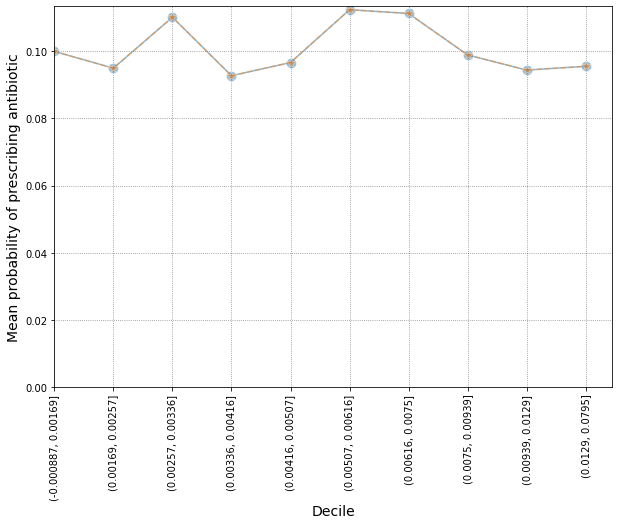


LR AUROC with development and validation data: 0.55789 and 0.50348
RF AUROC with development and validation data: 0.80933 and 0.49022
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.745118       NaN       NaN
age_cat_25_34                0.968091       NaN       NaN
age_cat_35_44                0.967236  0.000000       inf
age_cat_45_54                0.951705       NaN       NaN
age_cat_55_64                0.863572       NaN       NaN
age_cat_65_74                0.858355       NaN       NaN
age_cat_75_more              0.891884       NaN       NaN
sex_female                   0.694566       NaN       NaN
sex_male                     0.632028       NaN       NaN
CCI_cat_high                 0.803640       NaN       NaN
CCI_cat_low                  0.892113  0.000000       inf
CCI_cat_medium               0.844534       NaN       NaN
CCI_cat_very_high            0.906847  0.000000       inf
CCI_cat_very_low             0.7994

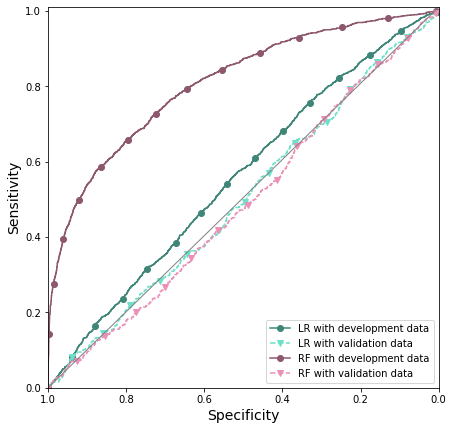

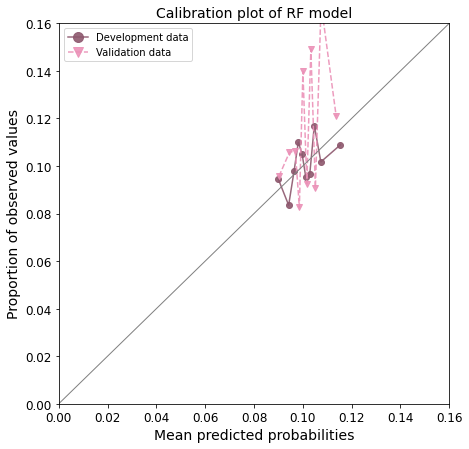

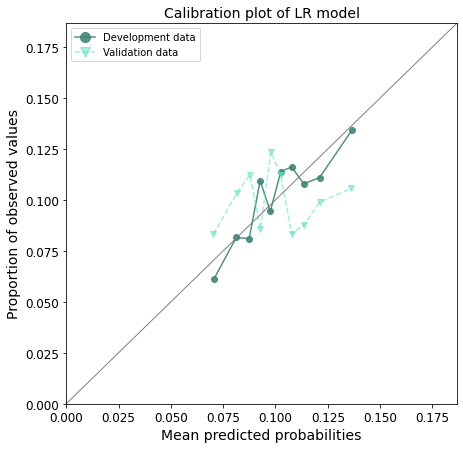

In [50]:
#build cox model for hosp prediction using non ab users' data
prob_pred_uti_no_abs_prevl, prob_pred_uti_no_abs_prevl_bin = cox_build('uti', 'prevl', data_uti_prevl, data_uti_no_abs_prevl)

#build rf and lr models
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk('uti', 'prevl', prob_pred_uti_no_abs_prevl)

#make summary table
make_summary_table('uti', 'prevl', prob_pred_enc_lr_rf_prevl)

#calibration plots of rf and lr
calibration_rf_lr('uti', 'prevl', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 28617 total observations, 28421 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 28617
number of events observed = 196
   partial log-likelihood = -1995.00
         time fit was run = 2023-06-27 16:05:23 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.09       0.91       0.22            -0.52             0.33                 0.60                 1.40
CCI_cat[T.medium]                0.03       1.03       0.24            -0.43             0.49                 0.65                 1.64
CCI_cat[T.high]                  0.06       1.07       0.28            -0.48             0.61                 0.62                 1.83
CCI_cat[T.very_high]             0.16       1.18       0.24            -0.31             0.63                 0.74                 1.89
age_cat[T.25_34]                -0.07       0.93       0.27            -0.59             0.45                 0.56                 1.57
age_cat[T.35_44]                -0.21       0.81       0.28            -0.75             0.34                 0.47                 1.40
age_cat[T.45_54]                 0.10       1.10       0.26            -0.40             0.60                 0.67                 1.83
age_cat[T.55_64]                 0.04       1.04       0.26            -0.47             0.55                 0.62                 1.73
age_cat[T.65_74]                -0.02       0.98       0.26            -0.54             0.49                 0.58                 1.63
age_cat[T.75_more]              -0.21       0.81       0.28            -0.75             0.33                 0.47                 1.39
antibacterial_brit              -0.10       0.91       0.05            -0.20             0.01                 0.82                 1.01
bmi_cat[T.obese]                 0.21       1.24       0.28            -0.34             0.77                 0.71                 2.17
bmi_cat[T.overweight]            0.12       1.12       0.35            -0.57             0.80                 0.57                 2.23
bmi_cat[T.underweight]           0.15       1.16       0.49            -0.80             1.11                 0.45                 3.03
bmi_cat[T.unknown]               0.23       1.25       0.30            -0.37             0.82                 0.69                 2.26
ethnicity[T.other]              -0.54       0.58       0.35            -1.22             0.14                 0.29                 1.15
ethnicity[T.unknown]            -0.69       0.50       0.26            -1.21            -0.17                 0.30                 0.84
ethnicity[T.white]              -0.43       0.65       0.23            -0.88             0.01                 0.42                 1.01
flu_vaccine[T.yes]               0.06       1.06       0.23            -0.40             0.51                 0.67                 1.67
imd[T.medium]                   -0.24       0.79       0.23            -0.68             0.21                 0.50                 1.24
imd[T.unaffluent]               -0.12       0.89       0.22            -0.55             0.31                 0.58                 1.37
imd[T.unknown]                   0.14       1.15       0.32            -0.48             0.76                 0.62                 2.13
imd[T.very_affluent]            -0.25       0.78       0.23            -0.70             0.20                 0.50                 1.22
imd[T.very_unaffluent]          -0.32       0.73       0.23            -0.78             0.13                 0.46                 1.14
region[T.east_midlands]          0.06       1.06       0.31           

13045


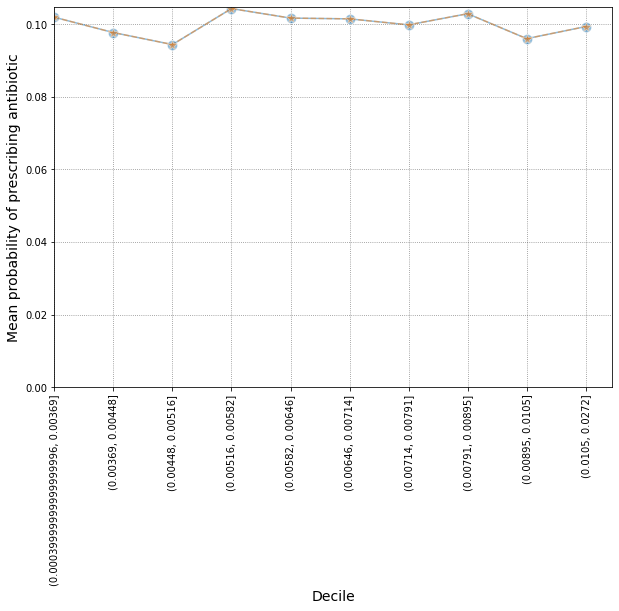


LR AUROC with development and validation data: 0.53384 and 0.49336
RF AUROC with development and validation data: 0.73253 and 0.49636
LR coefficients:
                                               OR  Lower CI  Upper CI
age_cat_15_24                           0.943922       NaN       NaN
age_cat_25_34                           0.892025       NaN       NaN
age_cat_35_44                           0.824930       NaN       NaN
age_cat_45_54                           0.863736       NaN       NaN
age_cat_55_64                           0.919816       NaN       NaN
age_cat_65_74                           0.950356       NaN       NaN
age_cat_75_more                         0.876293       NaN       NaN
sex_female                              0.689059  0.000000       inf
sex_male                                0.666946  0.000000       inf
CCI_cat_high                            0.807950       NaN       NaN
CCI_cat_low                             0.818379       NaN       NaN
CCI_cat_medium     

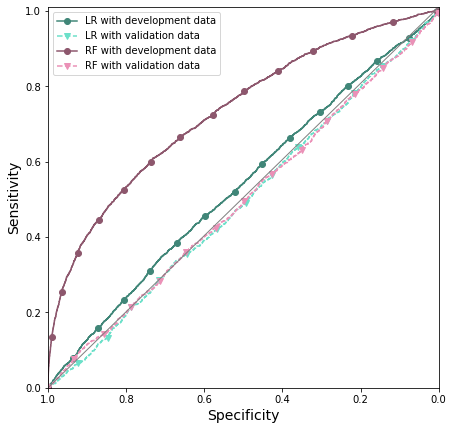

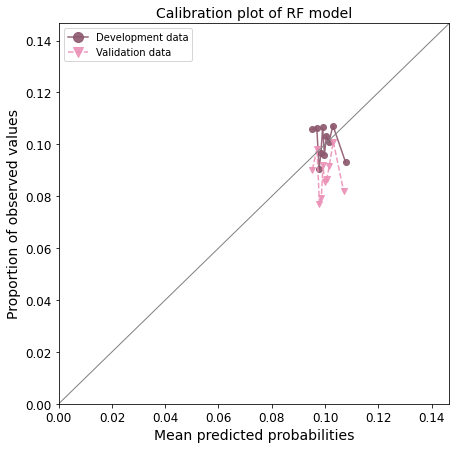

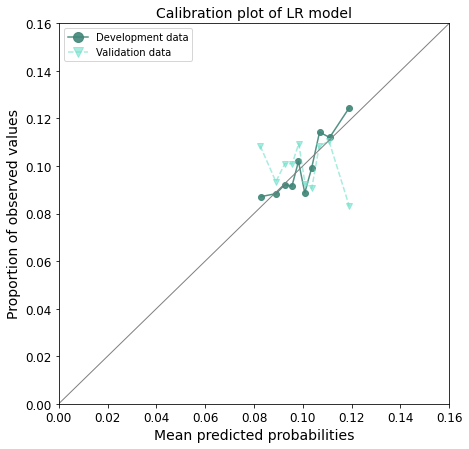

In [51]:
#build cox model for hosp prediction using non ab users' data
prob_pred_uti_no_abs_incdt_prepandemic, prob_pred_uti_no_abs_incdt_prepandemic_bin = cox_build('uti', 'incdt_prepandemic', data_uti_incdt_prepandemic, data_uti_no_abs_incdt_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic = lr_rf_build_risk('uti', 'incdt_prepandemic', prob_pred_uti_no_abs_incdt_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('uti', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic)

<lifelines.CoxPHFitter: fitted with 33093 total observations, 32888 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 33093
number of events observed = 205
   partial log-likelihood = -2108.32
         time fit was run = 2023-06-27 16:05:36 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       0.21            -0.46             0.37                 0.63                 1.45
CCI_cat[T.medium]                0.18       1.20       0.22            -0.26             0.62                 0.77                 1.85
CCI_cat[T.high]                  0.11       1.11       0.27            -0.42             0.63                 0.66                 1.88
CCI_cat[T.very_high]            -0.08       0.92       0.25            -0.57             0.41                 0.57                 1.50
age_cat[T.25_34]                 0.28       1.33       0.27            -0.25             0.82                 0.78                 2.27
age_cat[T.35_44]                -0.17       0.84       0.31            -0.77             0.43                 0.46                 1.53
age_cat[T.45_54]                 0.53       1.70       0.26             0.02             1.04                 1.02                 2.84
age_cat[T.55_64]                 0.02       1.02       0.29            -0.56             0.59                 0.57                 1.80
age_cat[T.65_74]                 0.14       1.15       0.28            -0.42             0.70                 0.66                 2.01
age_cat[T.75_more]               0.47       1.60       0.26            -0.05             0.99                 0.95                 2.68
antibacterial_brit               0.05       1.05       0.05            -0.05             0.14                 0.96                 1.15
bmi_cat[T.obese]                 0.24       1.27       0.28            -0.32             0.80                 0.73                 2.22
bmi_cat[T.overweight]           -0.05       0.95       0.36            -0.75             0.65                 0.47                 1.91
bmi_cat[T.underweight]           0.55       1.73       0.43            -0.29             1.38                 0.75                 3.99
bmi_cat[T.unknown]               0.26       1.30       0.30            -0.33             0.85                 0.72                 2.33
ethnicity[T.other]              -0.28       0.76       0.37            -1.00             0.45                 0.37                 1.56
ethnicity[T.unknown]            -0.02       0.98       0.28            -0.57             0.52                 0.57                 1.68
ethnicity[T.white]              -0.15       0.86       0.26            -0.66             0.36                 0.52                 1.44
flu_vaccine[T.yes]               0.28       1.32       0.21            -0.13             0.69                 0.88                 1.99
imd[T.medium]                    0.15       1.16       0.21            -0.26             0.56                 0.77                 1.74
imd[T.unaffluent]               -0.20       0.82       0.23            -0.64             0.25                 0.53                 1.29
imd[T.unknown]                   0.39       1.48       0.29            -0.19             0.96                 0.83                 2.62
imd[T.very_affluent]            -0.13       0.88       0.22            -0.56             0.31                 0.57                 1.36
imd[T.very_unaffluent]          -0.59       0.55       0.25            -1.09            -0.09                 0.34                 0.91
region[T.east_midlands]         -0.65       0.52       0.41           

13030


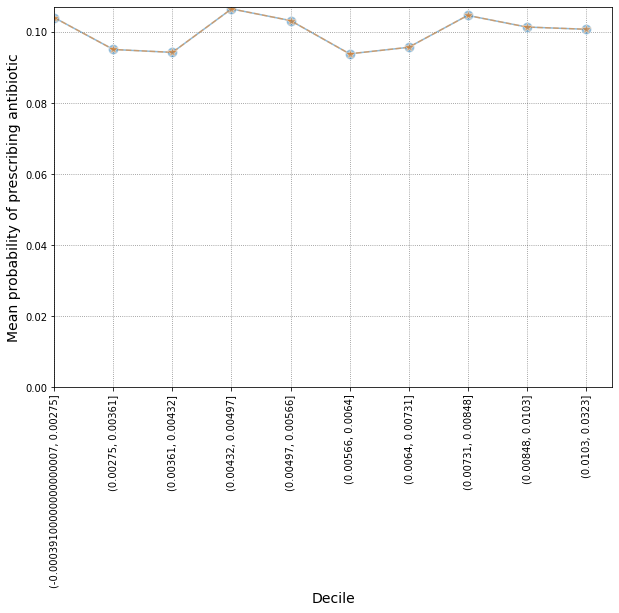


LR AUROC with development and validation data: 0.53614 and 0.50363
RF AUROC with development and validation data: 0.71155 and 0.50494
LR coefficients:
                                                OR  Lower CI  Upper CI
age_cat_15_24                            0.948336       NaN       NaN
age_cat_25_34                            0.838351       NaN       NaN
age_cat_35_44                            0.937637       NaN       NaN
age_cat_45_54                            0.872645       NaN       NaN
age_cat_55_64                            0.907651       NaN       NaN
age_cat_65_74                            0.882713       NaN       NaN
age_cat_75_more                          0.823133       NaN       NaN
sex_female                               0.646299  0.000000       inf
sex_male                                 0.663798  0.000000       inf
CCI_cat_high                             0.738589       NaN       NaN
CCI_cat_low                              0.854473       NaN       NaN
CCI_cat

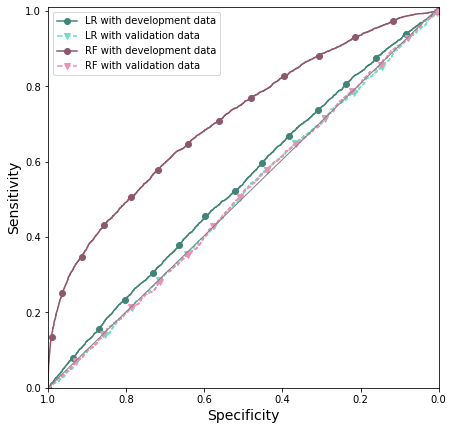

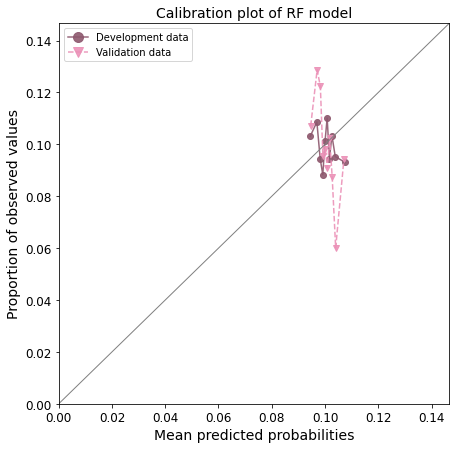

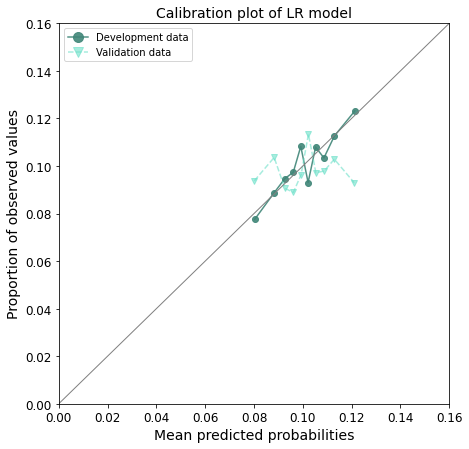

In [52]:
#build cox model for hosp prediction using non ab users' data
prob_pred_uti_no_abs_incdt_during_pandemic, prob_pred_uti_no_abs_incdt_during_pandemic_bin = cox_build('uti', 'incdt_during_pandemic', data_uti_incdt_during_pandemic, data_uti_no_abs_incdt_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic = lr_rf_build_risk('uti', 'incdt_during_pandemic', prob_pred_uti_no_abs_incdt_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('uti', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic)

<lifelines.CoxPHFitter: fitted with 46356 total observations, 46061 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 46356
number of events observed = 295
   partial log-likelihood = -3139.15
         time fit was run = 2023-06-27 16:05:51 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.04       1.04       0.18            -0.33             0.40                 0.72                 1.49
CCI_cat[T.medium]                0.05       1.05       0.20            -0.35             0.45                 0.70                 1.57
CCI_cat[T.high]                  0.45       1.56       0.22             0.02             0.87                 1.02                 2.40
CCI_cat[T.very_high]             0.43       1.54       0.20             0.05             0.82                 1.05                 2.27
age_cat[T.25_34]                -0.22       0.80       0.22            -0.65             0.21                 0.52                 1.23
age_cat[T.35_44]                -0.14       0.87       0.21            -0.56             0.29                 0.57                 1.33
age_cat[T.45_54]                -0.10       0.90       0.21            -0.52             0.32                 0.59                 1.37
age_cat[T.55_64]                -0.10       0.90       0.21            -0.52             0.31                 0.60                 1.37
age_cat[T.65_74]                -0.24       0.79       0.22            -0.68             0.20                 0.51                 1.22
age_cat[T.75_more]               0.06       1.06       0.21            -0.35             0.46                 0.71                 1.58
antibacterial_brit              -0.12       0.89       0.04            -0.21            -0.04                 0.81                 0.96
bmi_cat[T.obese]                -0.00       1.00       0.22            -0.43             0.42                 0.65                 1.52
bmi_cat[T.overweight]            0.09       1.09       0.26            -0.42             0.59                 0.66                 1.81
bmi_cat[T.underweight]           0.22       1.24       0.35            -0.47             0.91                 0.62                 2.47
bmi_cat[T.unknown]              -0.23       0.79       0.24            -0.70             0.23                 0.50                 1.26
ethnicity[T.other]              -0.14       0.87       0.29            -0.72             0.43                 0.49                 1.54
ethnicity[T.unknown]            -0.16       0.86       0.23            -0.61             0.30                 0.54                 1.35
ethnicity[T.white]              -0.15       0.86       0.21            -0.56             0.27                 0.57                 1.32
flu_vaccine[T.yes]              -0.27       0.76       0.22            -0.70             0.16                 0.50                 1.17
imd[T.medium]                   -0.02       0.98       0.18            -0.37             0.34                 0.69                 1.40
imd[T.unaffluent]               -0.22       0.80       0.19            -0.59             0.15                 0.55                 1.16
imd[T.unknown]                  -0.21       0.81       0.30            -0.81             0.38                 0.44                 1.47
imd[T.very_affluent]            -0.09       0.91       0.18            -0.45             0.26                 0.64                 1.30
imd[T.very_unaffluent]          -0.25       0.78       0.19            -0.62             0.12                 0.54                 1.13
region[T.east_midlands]         -0.19       0.83       0.27           

13068


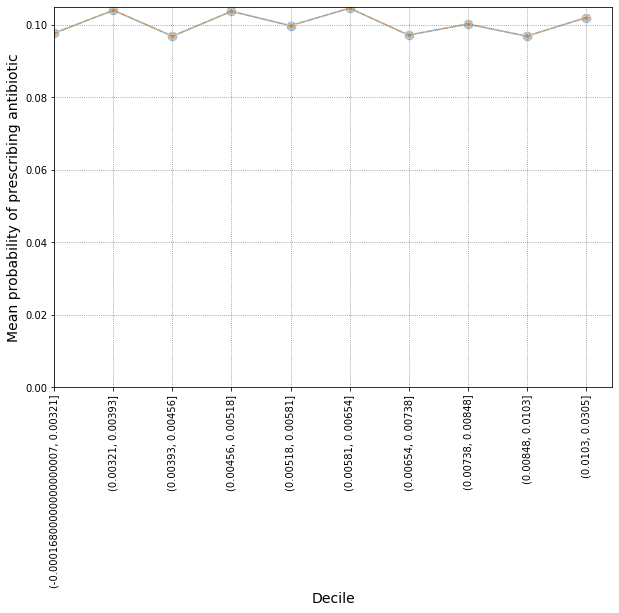


LR AUROC with development and validation data: 0.52959 and 0.50453
RF AUROC with development and validation data: 0.67778 and 0.50120
LR coefficients:
                                                OR  Lower CI  Upper CI
age_cat_15_24                            0.919997       NaN       NaN
age_cat_25_34                            0.865953       NaN       NaN
age_cat_35_44                            0.908153       NaN       NaN
age_cat_45_54                            0.850659       NaN       NaN
age_cat_55_64                            0.868958       NaN       NaN
age_cat_65_74                            0.935907       NaN       NaN
age_cat_75_more                          0.864416       NaN       NaN
sex_female                               0.651311  0.000000       inf
sex_male                                 0.664295  0.000000       inf
CCI_cat_high                             0.877394       NaN       NaN
CCI_cat_low                              0.825494       NaN       NaN
CCI_cat

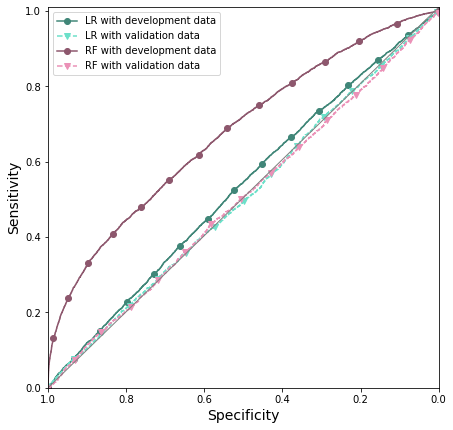

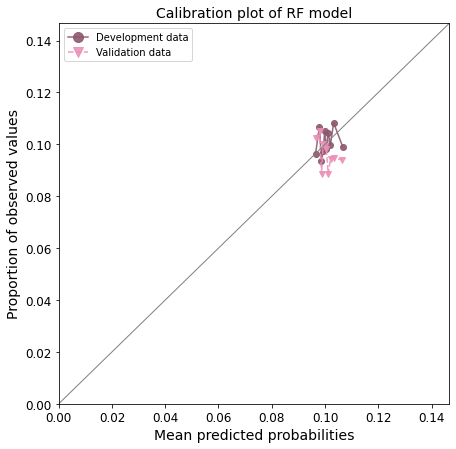

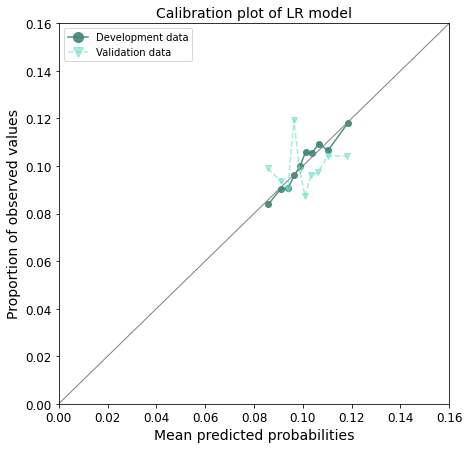

In [53]:
#build cox model for hosp prediction using non ab users' data
prob_pred_uti_no_abs_incdt_post_2nd_lockdown, prob_pred_uti_no_abs_incdt_post_2nd_lockdown_bin = cox_build('uti', 'incdt_post_2nd_lockdown', data_uti_incdt_post_2nd_lockdown, data_uti_no_abs_incdt_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown = lr_rf_build_risk('uti', 'incdt_post_2nd_lockdown', prob_pred_uti_no_abs_incdt_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('uti', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown)

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 3241 total observations, 3223 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 3241
number of events observed = 18
   partial log-likelihood = -120.40
         time fit was run = 2023-06-27 16:06:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.43       4.17       1.07            -0.66             3.52                 0.52                33.69
CCI_cat[T.medium]                0.37       1.44       1.24            -2.06             2.79                 0.13                16.32
CCI_cat[T.high]                  1.30       3.66       1.17            -0.99             3.59                 0.37                36.22
CCI_cat[T.very_high]             0.85       2.34       1.17            -1.44             3.15                 0.24                23.26
age_cat[T.25_34]                18.57   1.16e+08    5108.82         -9994.54         10031.68                 0.00                  inf
age_cat[T.35_44]                18.62   1.22e+08    5108.82         -9994.49         10031.73                 0.00                  inf
age_cat[T.45_54]                18.75   1.39e+08    5108.82         -9994.36         10031.86                 0.00                  inf
age_cat[T.55_64]                17.80   5.35e+07    5108.82         -9995.32         10030.91                 0.00                  inf
age_cat[T.65_74]                17.28   3.19e+07    5108.82         -9995.83         10030.39                 0.00                  inf
age_cat[T.75_more]              18.39   9.71e+07    5108.82         -9994.72         10031.50                 0.00                  inf
antibacterial_brit               0.15       1.16       0.17            -0.17             0.47                 0.84                 1.61
bmi_cat[T.obese]                -0.89       0.41       0.69            -2.25             0.47                 0.11                 1.59
bmi_cat[T.overweight]           -1.59       0.20       1.18            -3.91             0.73                 0.02                 2.08
bmi_cat[T.underweight]           0.09       1.09       1.20            -2.27             2.44                 0.10                11.45
bmi_cat[T.unknown]              -1.08       0.34       0.79            -2.64             0.47                 0.07                 1.60
ethnicity[T.other]              -0.33       0.72       1.04            -2.37             1.71                 0.09                 5.50
ethnicity[T.unknown]            -0.72       0.49       0.90            -2.48             1.04                 0.08                 2.83
ethnicity[T.white]              -0.65       0.52       0.80            -2.22             0.93                 0.11                 2.53
flu_vaccine[T.yes]              -0.73       0.48       1.06            -2.80             1.34                 0.06                 3.83
imd[T.medium]                  -17.23       0.00    5208.30        -10225.30         10190.85                 0.00                  inf
imd[T.unaffluent]              -17.13       0.00    5352.33        -10507.50         10473.24                 0.00                  inf
imd[T.unknown]                   2.43      11.41       1.18             0.13             4.74                 1.14               114.18
imd[T.very_affluent]             1.79       5.99       1.08            -0.32             3.90                 0.73                49.25
imd[T.very_unaffluent]           1.91       6.73       1.07            -0.20             4.01                 0.82                55.36
region[T.east_midlands]         -0.98       0.37       1.17            -3.2

13150


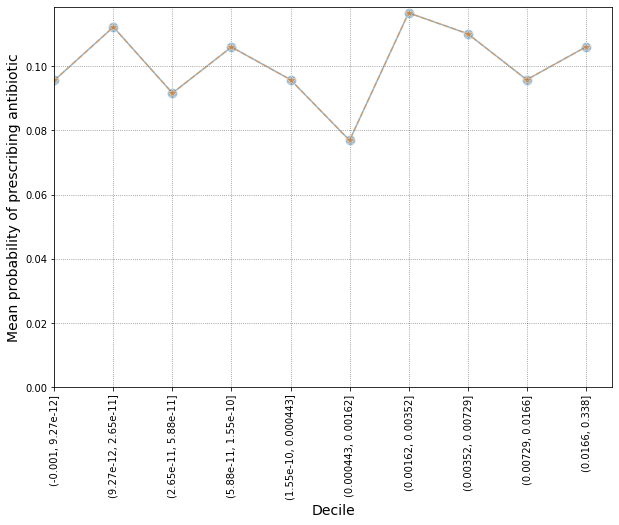


LR AUROC with development and validation data: 0.61261 and 0.46940
RF AUROC with development and validation data: 0.92935 and 0.51266
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                1.394403   0.00000       inf
age_cat_25_34                1.001731   0.00000       inf
age_cat_35_44                0.681676   0.00000       inf
age_cat_45_54                0.679022   0.00000       inf
age_cat_55_64                1.015644   0.00000       inf
age_cat_65_74                0.876243   0.00000       inf
age_cat_75_more              0.694204   0.00000       inf
sex_female                   0.697041   0.00000       inf
sex_male                     0.573056   0.00000       inf
CCI_cat_high                 0.560717       NaN       NaN
CCI_cat_low                  0.788786       NaN       NaN
CCI_cat_medium               0.966213       NaN       NaN
CCI_cat_very_high            0.769349       NaN       NaN
CCI_cat_very_low             1.2149

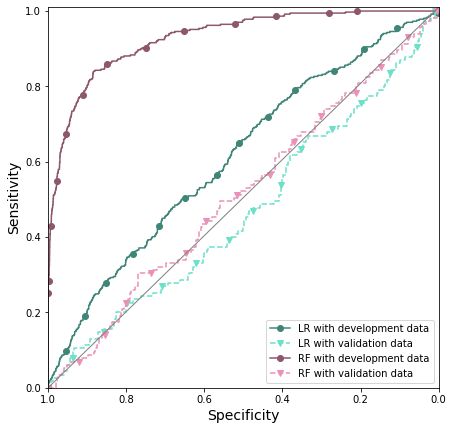

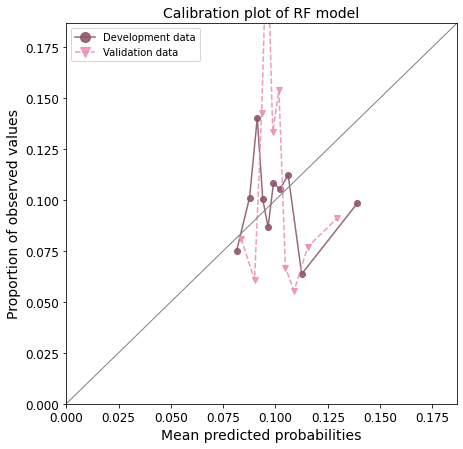

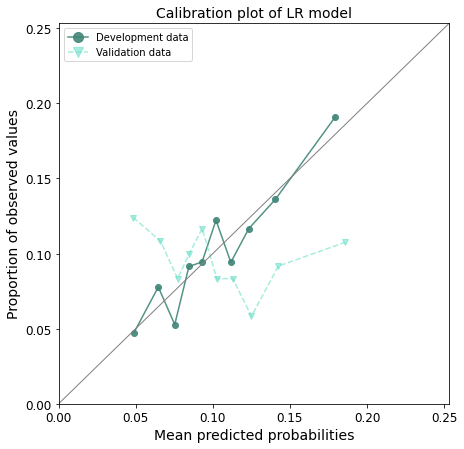

In [54]:
#build cox model for hosp prediction using non ab users' data
prob_pred_uti_no_abs_prevl_prepandemic, prob_pred_uti_no_abs_prevl_prepandemic_bin = cox_build('uti', 'prevl_prepandemic', data_uti_prevl_prepandemic, data_uti_no_abs_prevl_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic = lr_rf_build_risk('uti', 'prevl_prepandemic', prob_pred_uti_no_abs_prevl_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('uti', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic)

<lifelines.CoxPHFitter: fitted with 3635 total observations, 3606 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 3635
number of events observed = 29
   partial log-likelihood = -216.84
         time fit was run = 2023-06-27 16:06:18 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.26       1.29       0.60            -0.92             1.43                 0.40                 4.17
CCI_cat[T.medium]               -0.54       0.58       0.77            -2.04             0.97                 0.13                 2.64
CCI_cat[T.high]                 -0.25       0.78       0.87            -1.97             1.46                 0.14                 4.30
CCI_cat[T.very_high]             1.07       2.91       0.60            -0.11             2.24                 0.90                 9.42
age_cat[T.25_34]                -1.20       0.30       0.83            -2.82             0.42                 0.06                 1.52
age_cat[T.35_44]                -0.74       0.48       0.71            -2.14             0.66                 0.12                 1.94
age_cat[T.45_54]                -0.49       0.61       0.66            -1.77             0.80                 0.17                 2.22
age_cat[T.55_64]                -1.06       0.35       0.82            -2.68             0.56                 0.07                 1.74
age_cat[T.65_74]                 0.14       1.15       0.55            -0.94             1.22                 0.39                 3.39
age_cat[T.75_more]              -0.43       0.65       0.65            -1.71             0.85                 0.18                 2.34
antibacterial_brit              -0.04       0.96       0.14            -0.31             0.23                 0.74                 1.26
bmi_cat[T.obese]                 0.81       2.25       1.04            -1.23             2.86                 0.29                17.38
bmi_cat[T.overweight]            1.42       4.13       1.10            -0.74             3.57                 0.48                35.65
bmi_cat[T.underweight]         -16.11       0.00    4886.13         -9592.74          9560.53                 0.00                  inf
bmi_cat[T.unknown]               1.24       3.45       1.05            -0.83             3.30                 0.44                27.24
ethnicity[T.other]              -1.09       0.34       1.17            -3.39             1.21                 0.03                 3.34
ethnicity[T.unknown]            -0.18       0.83       0.69            -1.53             1.17                 0.22                 3.22
ethnicity[T.white]              -0.32       0.72       0.64            -1.57             0.93                 0.21                 2.53
flu_vaccine[T.yes]               0.05       1.05       0.62            -1.17             1.27                 0.31                 3.55
imd[T.medium]                   -0.95       0.39       0.61            -2.14             0.25                 0.12                 1.28
imd[T.unaffluent]               -0.64       0.53       0.57            -1.75             0.48                 0.17                 1.61
imd[T.unknown]                 -17.32       0.00    4183.46         -8216.75          8182.11                 0.00                  inf
imd[T.very_affluent]            -1.27       0.28       0.67            -2.58             0.05                 0.08                 1.05
imd[T.very_unaffluent]          -0.17       0.84       0.49            -1.14             0.80                 0.32                 2.22
region[T.east_midlands]         -1.23       0.29       1.12            -3.4

13075


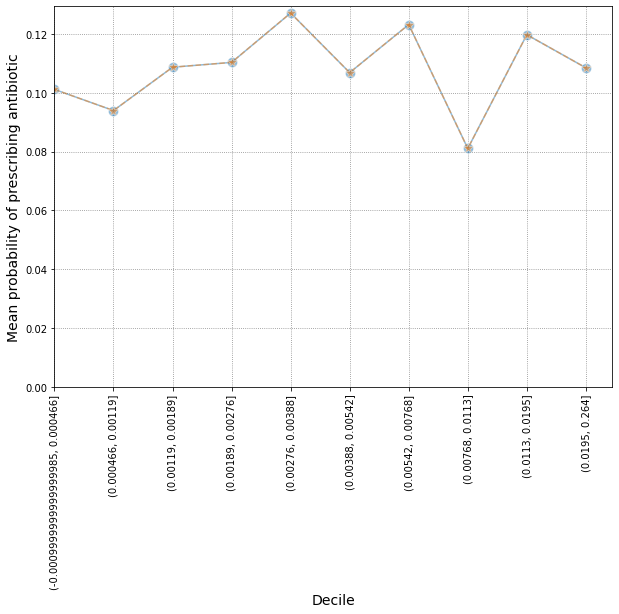


LR AUROC with development and validation data: 0.60193 and 0.47647
RF AUROC with development and validation data: 0.91622 and 0.49309
LR coefficients:
                                                OR  Lower CI  Upper CI
age_cat_15_24                            0.735927  0.000000       inf
age_cat_25_34                            1.029309  0.000000       inf
age_cat_35_44                            0.969622  0.000000       inf
age_cat_45_54                            0.997251  0.000000       inf
age_cat_55_64                            0.817561  0.000000       inf
age_cat_65_74                            0.748869  0.000000       inf
age_cat_75_more                          1.075451  0.000000       inf
sex_female                               0.721078       NaN       NaN
sex_male                                 0.668840       NaN       NaN
CCI_cat_high                             1.042339  0.000000       inf
CCI_cat_low                              0.934889  0.000000       inf
CCI_cat

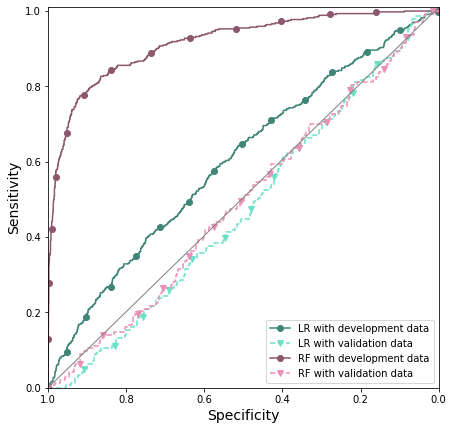

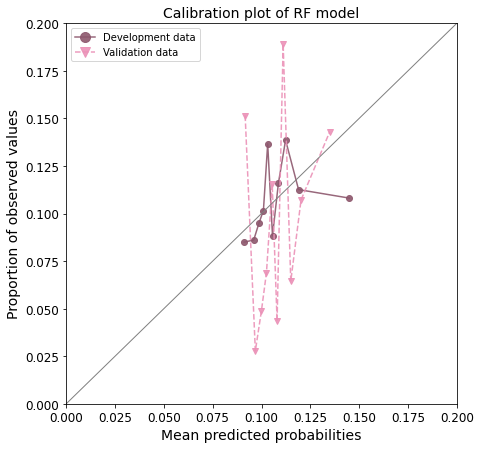

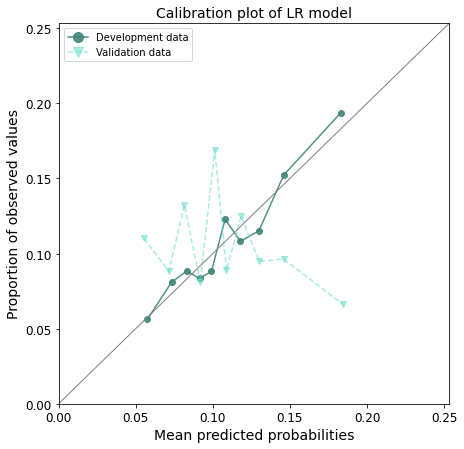

In [55]:
#build cox model for hosp prediction using non ab users' data
prob_pred_uti_no_abs_prevl_during_pandemic, prob_pred_uti_no_abs_prevl_during_pandemic_bin = cox_build('uti', 'prevl_during_pandemic', data_uti_prevl_during_pandemic, data_uti_no_abs_prevl_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic = lr_rf_build_risk('uti', 'prevl_during_pandemic', prob_pred_uti_no_abs_prevl_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('uti', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic)

<lifelines.CoxPHFitter: fitted with 5122 total observations, 5088 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 5122
number of events observed = 34
   partial log-likelihood = -268.18
         time fit was run = 2023-06-27 16:06:24 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.61       1.85       0.64            -0.65             1.88                 0.52                 6.54
CCI_cat[T.medium]                0.60       1.82       0.70            -0.76             1.96                 0.47                 7.13
CCI_cat[T.high]                  0.26       1.29       0.83            -1.36             1.87                 0.26                 6.52
CCI_cat[T.very_high]             0.91       2.50       0.68            -0.42             2.25                 0.66                 9.48
age_cat[T.25_34]                -0.98       0.37       0.84            -2.63             0.66                 0.07                 1.94
age_cat[T.35_44]                 0.30       1.35       0.59            -0.86             1.46                 0.42                 4.31
age_cat[T.45_54]                 0.13       1.14       0.61            -1.07             1.32                 0.34                 3.74
age_cat[T.55_64]                -0.52       0.59       0.74            -1.97             0.92                 0.14                 2.51
age_cat[T.65_74]                 0.04       1.04       0.61            -1.16             1.23                 0.31                 3.43
age_cat[T.75_more]              -0.09       0.92       0.64            -1.34             1.17                 0.26                 3.21
antibacterial_brit              -0.03       0.97       0.12            -0.28             0.21                 0.76                 1.23
bmi_cat[T.obese]                -0.55       0.58       0.51            -1.56             0.46                 0.21                 1.58
bmi_cat[T.overweight]           -0.81       0.44       0.74            -2.26             0.64                 0.10                 1.90
bmi_cat[T.underweight]           0.56       1.75       0.74            -0.90             2.02                 0.41                 7.53
bmi_cat[T.unknown]              -0.94       0.39       0.61            -2.14             0.26                 0.12                 1.29
ethnicity[T.other]               0.85       2.33       0.85            -0.82             2.51                 0.44                12.32
ethnicity[T.unknown]             0.46       1.59       0.79            -1.08             2.01                 0.34                 7.46
ethnicity[T.white]               0.18       1.19       0.75            -1.30             1.65                 0.27                 5.22
flu_vaccine[T.yes]              -0.70       0.50       0.74            -2.14             0.75                 0.12                 2.11
imd[T.medium]                    0.14       1.15       0.56            -0.96             1.23                 0.38                 3.42
imd[T.unaffluent]               -0.71       0.49       0.71            -2.10             0.68                 0.12                 1.97
imd[T.unknown]                   1.20       3.32       0.61             0.00             2.40                 1.00                11.01
imd[T.very_affluent]            -0.65       0.52       0.71            -2.05             0.74                 0.13                 2.09
imd[T.very_unaffluent]           0.58       1.78       0.52            -0.44             1.60                 0.64                 4.94
region[T.east_midlands]          0.74       2.10       1.23            -1.6

13038


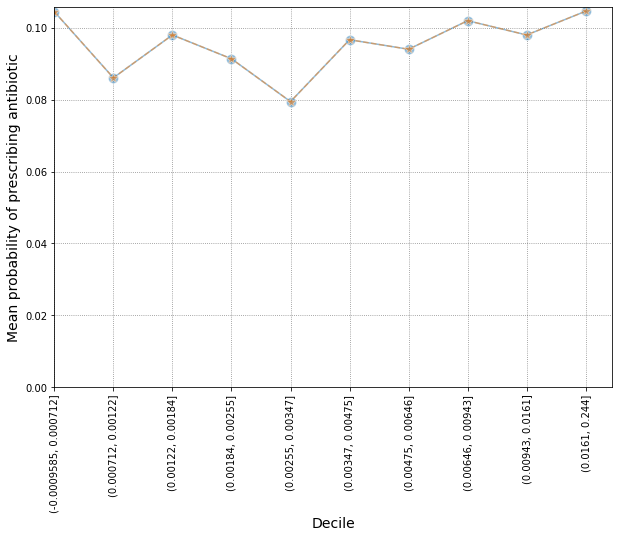


LR AUROC with development and validation data: 0.58292 and 0.47039
RF AUROC with development and validation data: 0.90157 and 0.46524
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.742454       NaN       NaN
age_cat_25_34                0.682187       NaN       NaN
age_cat_35_44                0.996263       NaN       NaN
age_cat_45_54                1.021615       NaN       NaN
age_cat_55_64                0.842257       NaN       NaN
age_cat_65_74                0.967653       NaN       NaN
age_cat_75_more              1.038625       NaN       NaN
sex_female                   0.729956       NaN       NaN
sex_male                     0.597806       NaN       NaN
CCI_cat_high                 0.655739       NaN       NaN
CCI_cat_low                  0.841279       NaN       NaN
CCI_cat_medium               1.055345       NaN       NaN
CCI_cat_very_high            0.983677       NaN       NaN
CCI_cat_very_low             0.7619

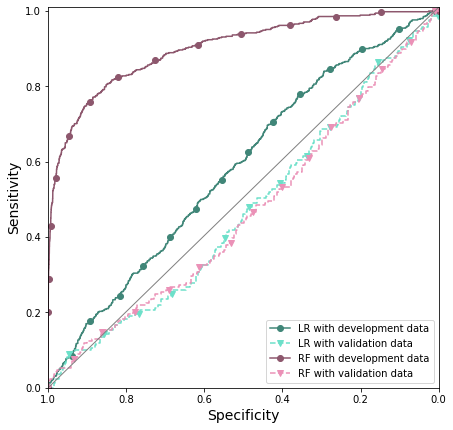

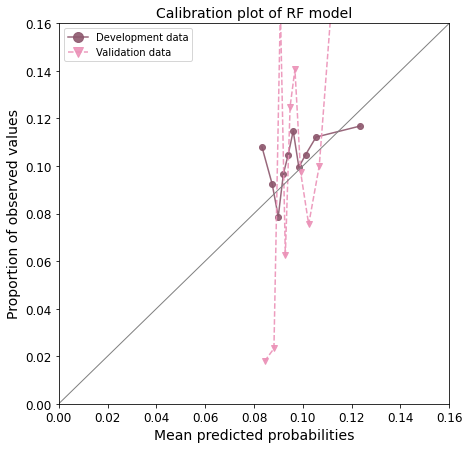

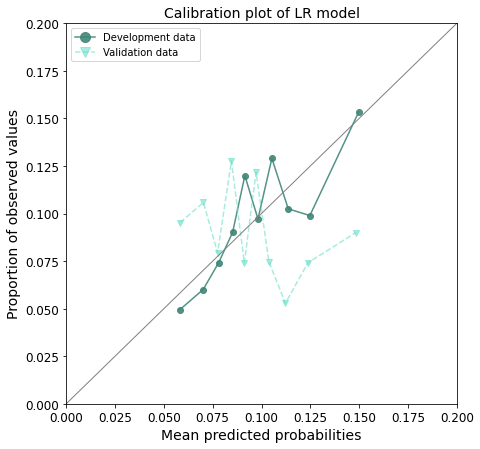

In [56]:
#build cox model for hosp prediction using non ab users' data
prob_pred_uti_no_abs_prevl_post_2nd_lockdown, prob_pred_uti_no_abs_prevl_post_2nd_lockdown_bin = cox_build('uti', 'prevl_post_2nd_lockdown', data_uti_prevl_post_2nd_lockdown, data_uti_no_abs_prevl_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown = lr_rf_build_risk('uti', 'prevl_post_2nd_lockdown', prob_pred_uti_no_abs_prevl_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('uti', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown)